# Imports

In [1]:
import os
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn import cluster
from shapely.geometry import Point
from sklearn.metrics import silhouette_score
%matplotlib inline

/Users/JordanVani/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Load Data

In [2]:
if "hadive-data.csv" not in os.listdir("../data/external/"):
    os.system("wget https://www.dropbox.com/s/jb02u19covpax3b/hadive-data.csv?dl=0 -O ../data/external/hadive-data.csv")

df = pd.read_csv("../data/external/hadive-data.csv",
                 usecols=["cam_id", "date", "cam_dir", "count", "imtime"],
                 dtype={"cam_id": int, "date": str, "cam_dir": str, "count": int, "imtime": str},
                 parse_dates=["date"], infer_datetime_format=True, index_col="date")

print df.dtypes
df.head(2)

cam_id      int64
cam_dir    object
count       int64
imtime     object
dtype: object


,cam_id,cam_dir,count,imtime
date,,,,
2017-06-27 20:09:22,368,S,1,NaN
2017-06-27 20:09:23,360,NaN,1,NaN


In [3]:
cams = pd.read_csv("../data/external/cameras.csv")
cams.head(2)

,cam_id,cctv_id,description,lat,long,people,ribbon,boro,zipcode
0,112,83,SIE @ Richmond Ave,40.614885,-74.157435,0.0,1.0,Staten Island,10314
1,121,129,LIE @ Kissena Blvd,40.738943,-73.815047,1.0,0.0,Queens,11367


# Camera Average (Weekday, Weekend, and July 4th).

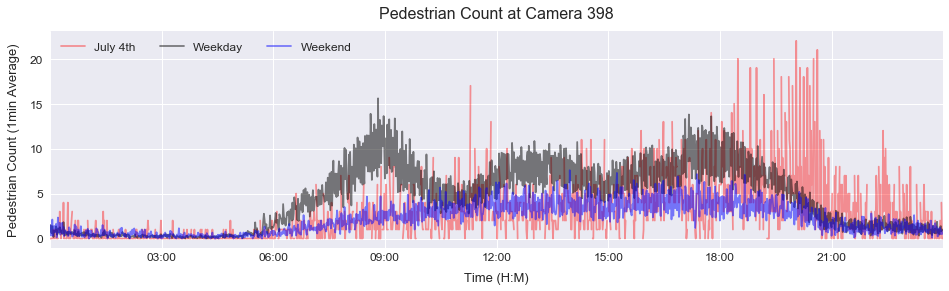

In [4]:
def groupby_min(df, dur):
    temp = df.copy()
    temp.index = map(lambda x: pd.datetime.combine(datetime.datetime.today(), x), temp.index.time)
    return temp.resample(dur).mean()

def plot_camera_avg(df, cam=None):
    if cam == None:
        weekday = groupby_min(df[(df.index.weekday < 5) & (df.index != "2017-07-04")], "1Min")
        weekend = groupby_min(df[(df.index.weekday >= 5)], "1Min")
        july4 = groupby_min(df[(df.index > "2017-07-04") & (df.index < "2017-07-05")], "1Min")
    else:
        weekday = groupby_min(df[(df.index.weekday < 5) & (df.cam_id == cam) & (df.index != "2017-07-04")], "1Min")
        weekend = groupby_min(df[(df.index.weekday >= 5) & (df.cam_id == cam)], "1Min")
        july4 = groupby_min(df[(df.index > "2017-07-04") & (df.index < "2017-07-05") & (df.cam_id == cam)], "1Min")

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))
    
    july4["count"].plot(ax=ax1, c="r", alpha=0.4, label="July 4th")
    weekday["count"].plot(ax=ax1, c="k", alpha=0.5, label="Weekday")
    weekend["count"].plot(ax=ax1, c="b", alpha=0.5, label="Weekend")

    ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    ax1.grid(True, which="both")
    ax1.tick_params(axis="both", which="both", labelsize=12)
    ax1.legend(ncol=3, fontsize=12)
    
    return fig, ax1

cam_id = 398 # Edit camera id here.
fig, ax1 = plot_camera_avg(df, cam_id) 

ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Pedestrian Count at Camera {}".format(cam_id), fontsize=16, y=1.03)

# Cameras Average (Manhattan)

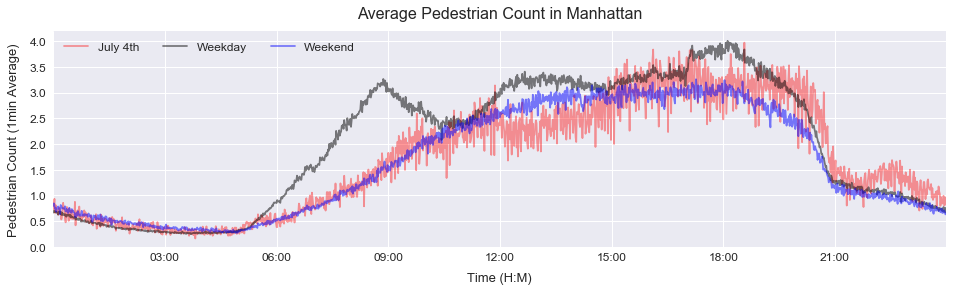

In [5]:
df_man = df[df["cam_id"].isin(cams[(cams["boro"] == "Manhattan") & (cams["people"] == 1.)].cam_id.unique())]
fig, ax1 = plot_camera_avg(df_man)
ax1.set_xlabel("Time (H:M)", fontsize=13, labelpad=10)
ax1.set_ylabel("Pedestrian Count (1min Average)", fontsize=13, labelpad=10)
ax1.set_title("Average Pedestrian Count in Manhattan", fontsize=16, y=1.03)

# Timeseries Image
## Weekday

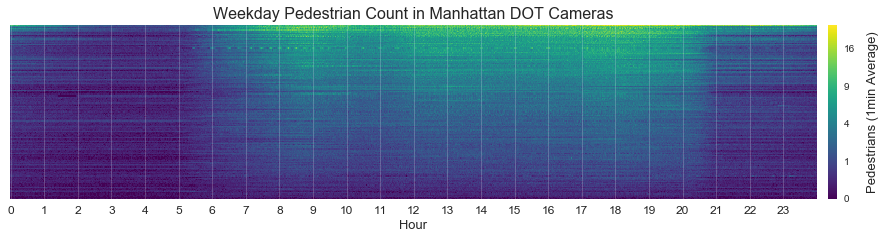

In [6]:
df_man_weekday = df_man[(df_man.index.weekday < 5)]
ts = []
for cam in df_man_weekday.groupby("cam_id").mean().sort_values("count", ascending=False).index:
    d = [np.sqrt(i) for i in groupby_min(pd.DataFrame(df_man_weekday[df_man_weekday["cam_id"] == cam]["count"]), "1Min")["count"].values]
    if len(d) == 1440:
        ts.append(d)
        ts.append(d)
ts = np.array(ts)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts, cmap="viridis")
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
cbar.ax.set_yticklabels([0, 1, 4, 9, 16, 25, 36])
ax1.set_title("Weekday Pedestrian Count in Manhattan DOT Cameras", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Pedestrians (1min Average)", fontsize=13, labelpad=50)

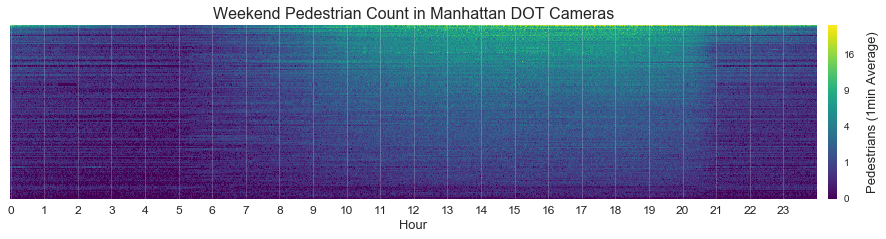

In [7]:
df_man_weekend = df_man[df_man.index.weekday >= 5]
ts = []
for cam in df_man_weekend.groupby("cam_id").mean().sort_values("count", ascending=False).index:
    d = [np.sqrt(i) for i in groupby_min(pd.DataFrame(df_man_weekend[df_man_weekend["cam_id"] == cam]["count"]), "1Min")["count"].values]
    if len(d) == 1440:
        ts.append(d)
        ts.append(d)
ts = np.array(ts)

fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(16, 3))
im = ax1.imshow(ts, cmap="viridis")
fig.tight_layout()
ax1.grid(alpha=0.2)
ax1.set_yticks([])
ax1.set_xticklabels(range(24))
ax1.set_xticks(np.arange(0, 1440, 60))
cbar = fig.colorbar(im, ax=ax1, pad=0.01)
cbar.ax.set_yticklabels([0, 1, 4, 9, 16, 25, 36])
ax1.set_title("Weekend Pedestrian Count in Manhattan DOT Cameras", fontsize=16)
ax1.set_xlabel("Hour", fontsize=13)
ax1.yaxis.set_label_position("right")
ax1.tick_params(axis="both", which="both", labelsize=12)
ax1.set_ylabel("Pedestrians (1min Average)", fontsize=13, labelpad=50)

# Clustering
## Prep spatial data.

In [8]:
nyc = gpd.read_file("../data/external/nyc_shp/nybb.shp")
nyc = nyc.to_crs({'init': 'epsg:4326'})

geometry = [Point(xy) for xy in zip(cams["long"], cams["lat"])]
cams.drop(["long", "lat"],  axis=1, inplace=True)
cams = gpd.GeoDataFrame(cams, crs={'init': 'epsg:4326'}, geometry=geometry)

In [9]:
temp = []
for cam in df_man["cam_id"].unique():
    t = groupby_min(df_man[df_man["cam_id"] == cam], "1Min")
    t.columns = ["cam_id", str(cam)]
    temp.append(t[str(cam)])
    
df_clust = pd.concat(temp, axis=1)
df_clust = (df_clust - df_clust.min()) / (df_clust.max() - df_clust.min())
df_clust = df_clust.T
df_clust.index = pd.to_numeric(df_clust.index)
df_clust.head(2)

,2017-08-29 00:00:00,2017-08-29 00:01:00,2017-08-29 00:02:00,2017-08-29 00:03:00,2017-08-29 00:04:00,2017-08-29 00:05:00,2017-08-29 00:06:00,2017-08-29 00:07:00,2017-08-29 00:08:00,2017-08-29 00:09:00,...,2017-08-29 23:50:00,2017-08-29 23:51:00,2017-08-29 23:52:00,2017-08-29 23:53:00,2017-08-29 23:54:00,2017-08-29 23:55:00,2017-08-29 23:56:00,2017-08-29 23:57:00,2017-08-29 23:58:00,2017-08-29 23:59:00
368,0.064198,0.052052,0.145903,0.072952,0.192593,0.145903,0.131313,0.101365,0.099617,0.127451,...,0.204265,0.228704,0.058361,0.175084,0.160494,0.139376,0.145903,0.226580,0.117117,0.070806
360,0.000000,0.029923,0.100649,0.033550,0.094898,0.033550,0.100649,0.058271,0.038177,0.065126,...,0.067100,0.027679,0.000000,0.067100,0.033550,0.087406,0.067100,0.032563,0.029923,0.033550


## Kmeans

In [10]:
for n_clusters in range(2, 7):
    clust = cluster.KMeans(n_clusters=n_clusters)
    clust_labels = clust.fit_predict(df_clust)
    print "For {} clusters, the average silhouette score is: {}".format(n_clusters, silhouette_score(df_clust, clust_labels))

For 2 clusters, the average silhouette score is: 0.180185198496
For 3 clusters, the average silhouette score is: 0.11429392977
For 4 clusters, the average silhouette score is: 0.10426472741
For 5 clusters, the average silhouette score is: 0.0729521711878
For 6 clusters, the average silhouette score is: 0.0659718952349


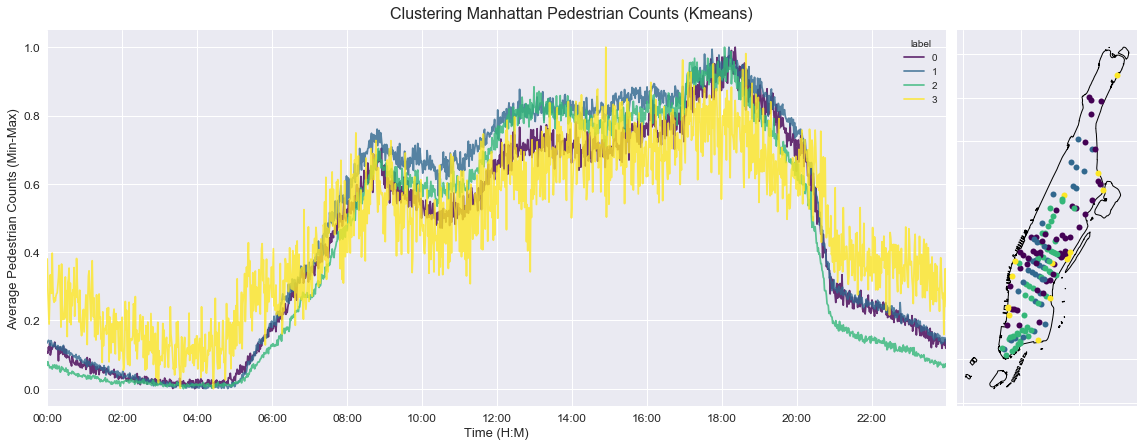

In [11]:
clust = cluster.KMeans(n_clusters=4).fit(df_clust)
labels = pd.DataFrame(zip(df_clust.index, clust.labels_), columns=["cam_id", "label"])
cams_clust = cams.merge(labels, on="cam_id", how="right")

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), gridspec_kw = {'width_ratios':[5, 1]})

df_clust_cams = df_clust.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_mean = df_clust_cams.groupby("label").mean().T
df_clust_mean = (df_clust_mean - df_clust_mean.min()) / (df_clust_mean.max() - df_clust_mean.min())
df_clust_mean.plot(ax=ax1, cmap="viridis", alpha=0.8)

nyc[nyc["BoroName"] == "Manhattan"].plot(ax=ax2, facecolor="none")
cams_clust.plot(ax=ax2, column="label", cmap="viridis", markersize=6)

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.set_ylabel("Average Pedestrian Counts (Min-Max)", fontsize=13)
ax1.set_xlabel("Time (H:M)", fontsize=13)
ax1.tick_params(axis="both", which="both", labelsize=12)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
fig.suptitle("Clustering Manhattan Pedestrian Counts (Kmeans)", fontsize=16, y=1.03)
fig.autofmt_xdate(rotation=0, ha="center")
plt.tight_layout()

## Agglomerative Clustering

In [12]:
for n_clusters in range(2, 7):
    clust = cluster.AgglomerativeClustering(n_clusters=n_clusters)
    clust_labels = clust.fit_predict(df_clust)
    print "For {} clusters, the average silhouette score is: {}".format(n_clusters, silhouette_score(df_clust, clust_labels))

For 2 clusters, the average silhouette score is: 0.248024681106
For 3 clusters, the average silhouette score is: 0.0758398608262
For 4 clusters, the average silhouette score is: 0.0820488064454
For 5 clusters, the average silhouette score is: 0.0783455584767
For 6 clusters, the average silhouette score is: 0.0667986614976


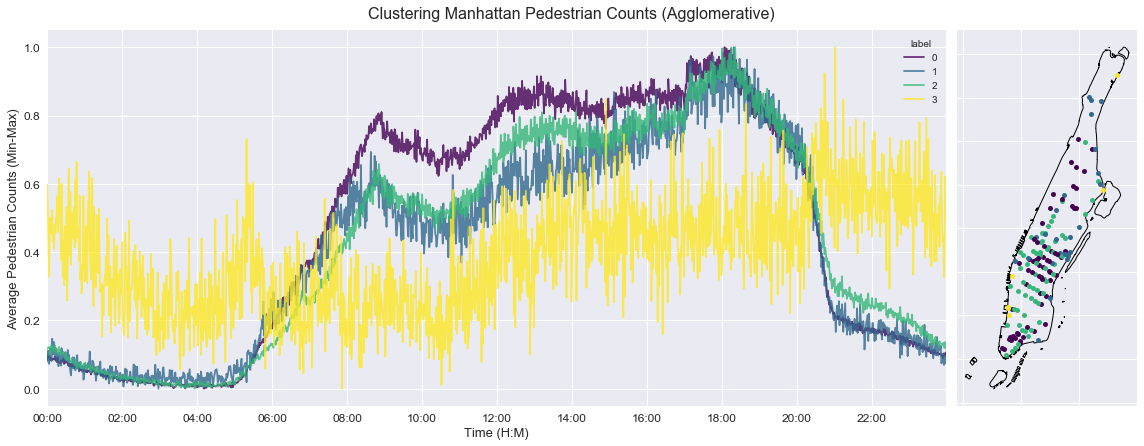

In [13]:
clust = cluster.AgglomerativeClustering(n_clusters=4).fit(df_clust)
labels = pd.DataFrame(zip(df_clust.index, clust.labels_), columns=["cam_id", "label"])
cams_clust = cams.merge(labels, on="cam_id", how="right")

fig, [ax1, ax2] = plt.subplots(nrows=1, ncols=2, figsize=(16, 6), gridspec_kw = {'width_ratios':[5, 1]})

df_clust_cams = df_clust.merge(labels.set_index("cam_id"), how="right", left_index=True, right_index=True)
df_clust_mean = df_clust_cams.groupby("label").mean().T
df_clust_mean = (df_clust_mean - df_clust_mean.min()) / (df_clust_mean.max() - df_clust_mean.min())
df_clust_mean.plot(ax=ax1, cmap="viridis", alpha=0.8)

nyc[nyc["BoroName"] == "Manhattan"].plot(ax=ax2, facecolor="none")
cams_clust.plot(ax=ax2, column="label", cmap="viridis", markersize=5)

ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax1.set_ylabel("Average Pedestrian Counts (Min-Max)", fontsize=13)
ax1.set_xlabel("Time (H:M)", fontsize=13)
ax1.tick_params(axis="both", which="both", labelsize=12)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
fig.suptitle("Clustering Manhattan Pedestrian Counts (Agglomerative)", fontsize=16, y=1.03)
fig.autofmt_xdate(rotation=0, ha="center")
plt.tight_layout()